In [16]:
import pandas as pd
import tushare as ts
import os
import sys
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [10]:
%%time

hs300_list = list(ts.get_hs300s()['code'])
print(hs300_list)

['600000', '600008', '600009', '600010', '600011', '600015', '600016', '600018', '600019', '600021', '600023', '600028', '600029', '600030', '600031', '600036', '600038', '600048', '600050', '600061', '600066', '600068', '600074', '600085', '600089', '600100', '600104', '600109', '600111', '600115', '600118', '600153', '600157', '600170', '600177', '600188', '600196', '600208', '600219', '600221', '600233', '600271', '600276', '600297', '600309', '600332', '600340', '600352', '600362', '600369', '600372', '600373', '600376', '600383', '600390', '600406', '600415', '600436', '600482', '600485', '600489', '600498', '600518', '600519', '600522', '600535', '600547', '600549', '600570', '600583', '600585', '600588', '600606', '600637', '600649', '600660', '600663', '600674', '600682', '600685', '600688', '600690', '600703', '600704', '600705', '600739', '600741', '600795', '600804', '600816', '600820', '600827', '600837', '600871', '600886', '600887', '600893', '600895', '600900', '600909',

In [20]:
os.getcwd()
# for symbol in hs300_list[:]:
for symbol in ['399300']:
    df = ts.get_k_data(code=symbol, index=True, start='2008-01-01', end='2018-05-01')
#     df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2008-01-01', end='2018-05-01')
    datafile = '../database/market/%s.csv' % symbol
    df.to_csv(datafile, index=False, encoding='utf-8')
    print(datafile)
    time.sleep(1)

'D:\\4399IronMan\\p\\qa\\PTQACode\\ML4M\\notebook'

../database/market/399300.csv


In [21]:
%%time

stock_df_dict = {}

for symbol in hs300_list + ['399300']:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期，和news_df['publish_time']一致
    stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    stock_df.set_index(['date'], inplace=True)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)

    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df


Wall time: 5min 25s


In [43]:
stock_df_dict['000983'].loc['2008-04-10']

close         16.40300
pct_change     0.03326
Name: 2008-04-10, dtype: float64

In [47]:
%%time

### Turtle

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-01-02'
# start_date = '2017-01-03'
end_date = '2018-04-27'

yesterday = None

show_df = None
show_df = stock_df_dict['399300'].copy()
show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['399300'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue


    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        N = 10
        try:
            is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == (stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min()).loc[today])
        except:
            print(stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min())
            raise 'FUCK'
#         print(is_sell)
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s 退出 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in hs300_list:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        try:
            # turtle buy N days
            N = 20
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[today])

            if is_buy:
                if CASH < 10000:
                    continue
                buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
                CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#                 hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
                hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0])
#                 print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0))
                recode_df = recode_df.append(
                    {
                        'date': today,
                        'ops': 'BUY',
                        'reason': 'ENTER',
                        'symbol': symbol,
                        'count': buy,
                        'price': stock_df_dict[symbol].loc[today, 'close'],
                        'buy_price': stock_df_dict[symbol].loc[today, 'close'],
    #                     'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                        'expect': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
        except:
            print(symbol, today, 'FUCK')
            raise 'FUCK'
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

s_p = stock_df_dict['399300'].loc[start_date, 'close']
e_p = stock_df_dict['399300'].loc[end_date, 'close']
print('399300', s_p, e_p, e_p / s_p)


9602.909
[[Period('2018-03-21', 'D'), '600028', 309, 6.8499999999999996, 0], [Period('2018-03-22', 'D'), '600372', 208, 14.68, 0], [Period('2018-03-23', 'D'), '000768', 181, 16.27, 0], [Period('2018-03-26', 'D'), '002007', 57, 28.620000000000001, 0], [Period('2018-04-02', 'D'), '600038', 21, 50.270000000000003, 0], [Period('2018-04-04', 'D'), '600637', 58, 17.34, 0], [Period('2018-04-12', 'D'), '600028', 291, 6.9400000000000004, 0], [Period('2018-04-12', 'D'), '600031', 210, 8.6500000000000004, 0], [Period('2018-04-12', 'D'), '600406', 86, 17.0, 0], [Period('2018-04-12', 'D'), '600436', 14, 89.260000000000005, 0], [Period('2018-04-13', 'D'), '600406', 117, 17.27, 0], [Period('2018-04-13', 'D'), '002602', 37, 35.609999999999999, 0], [Period('2018-04-13', 'D'), '002624', 34, 35.329999999999998, 0], [Period('2018-04-16', 'D'), '601877', 57, 27.5, 0], [Period('2018-04-17', 'D'), '601021', 83, 32.859999999999999, 0], [Period('2018-04-18', 'D'), '600376', 422, 8.8800000000000008, 0], [Period

In [50]:
%%time

### BT

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-01-02'
# start_date = '2017-01-03'
end_date = '2018-04-27'

yesterday = None

# show_df = None
# show_df = stock_df_dict['399300'].copy()
show_df['CASH'] = pd.np.nan
show_df['PROPERTY'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['399300'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue


    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s win SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif stock_df_dict[order[1]].loc[today, 'close'] / order[4] < 0.75:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s loss SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'LOSS',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif today - order[0] > 30:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s TIMEUP SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'TIMEUP',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in hs300_list:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        # buy drop wait rise back
        is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
           
        if is_buy:
            if stock_df_dict[symbol].loc[today, 'close'] < stock_df_dict[symbol].shift(7).loc[today, 'close']:
                continue
            if CASH < 10000:
                continue
            buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1))])
#             print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)),
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

s_p = stock_df_dict['399300'].loc[start_date, 'close']
e_p = stock_df_dict['399300'].loc[end_date, 'close']
print('399300', s_p, e_p, e_p / s_p)


9952.966
[[Period('2016-12-23', 'D'), '600485', 93, 14.59, 23.708000000000002], [Period('2018-03-28', 'D'), '600690', 67, 17.18, 20.74], [Period('2018-04-10', 'D'), '600157', 485, 2.4500000000000002, 2.45], [Period('2018-04-13', 'D'), '000792', 84, 12.98, 15.25], [Period('2018-04-26', 'D'), '600703', 56, 19.25, 9.82], [Period('2018-04-27', 'D'), '600372', 75, 14.58, 9.87]]
16714.156
399300 5385.1 3756.88 0.697643497799
Wall time: 5min 53s


d:\python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
d:\python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
d:\python3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

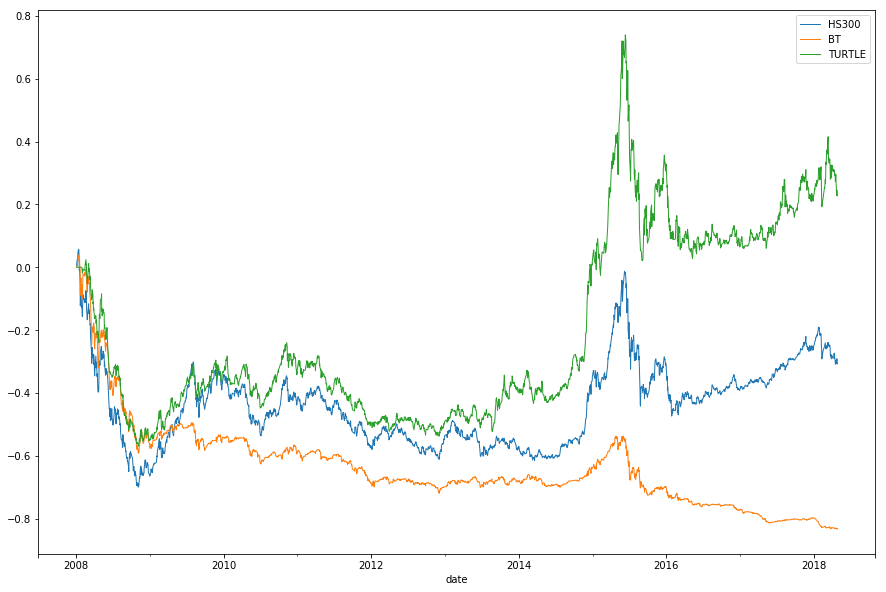

In [51]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False)
df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
df['PROPERTY'] = (df['PROPERTY'] - df.head(1)['PROPERTY'].values) / df.head(1)['PROPERTY'].values
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.head(1)['PROPERTY_T'].values) / df.head(1)['PROPERTY_T'].values
# df['CASH'] = df['CASH'] / df.head(1)['CASH'].values
# stock_df_dict['NDX']

ax = df.plot(kind='line', y='close', label='HS300', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY', secondary_y=False, label='BT', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T', label='TURTLE', secondary_y=False, linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()